# 데이터 로딩

In [1]:
# 데이터 분석
import pandas as pd
import numpy as np
import random as rnd

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 기계 학습
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [2]:
# 데이터 로딩
train = pd.read_csv('./data_bike/train.csv')
test = pd.read_csv('./data_bike/test.csv')

In [3]:
#데이터 확인
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 데이터 시각화 및 전처리

In [4]:
#datetime을 시간 단위 별로 구분
train['datetime']=pd.to_datetime(train['datetime'])
train['year']=train['datetime'].dt.year
train['month']=train['datetime'].dt.month
train['day']=train['datetime'].dt.day
train['hour']=train['datetime'].dt.hour
train['min']=train['datetime'].dt.minute
train['sec']=train['datetime'].dt.second
train['dayofweek']=train['datetime'].dt.dayofweek
train[['datetime','year','month','day','hour','min','sec','dayofweek']].head()

,datetime,year,month,day,hour,min,sec,dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,2011,1,1,4,0,0,5


In [5]:
#season 오류 수정
train['cor_season']=train['season']
for i in range(train.shape[0]):
    if train.loc[i, 'month'] in [3, 4, 5]:
        train.loc[i, 'cor_season']=1
    elif train.loc[i, 'month'] in [6,7,8]:
        train.loc[i, 'cor_season']=2
    elif train.loc[i, 'month'] in [9,10,11]:
        train.loc[i, 'cor_season']=3
    elif train.loc[i, 'month'] in [12,1,2]:
        train.loc[i, 'cor_season']=4

In [6]:
train[['datetime','season','cor_season']].head()

,datetime,season,cor_season
0,2011-01-01 00:00:00,1,4
1,2011-01-01 01:00:00,1,4
2,2011-01-01 02:00:00,1,4
3,2011-01-01 03:00:00,1,4
4,2011-01-01 04:00:00,1,4


In [7]:
train['windspeed'].value_counts().head()

0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
Name: windspeed, dtype: int64

In [8]:
#weather가 4인 것이 하나 밖에 없으므로 행 삭제
train[train['weather']==4]
train=train.drop([5631])

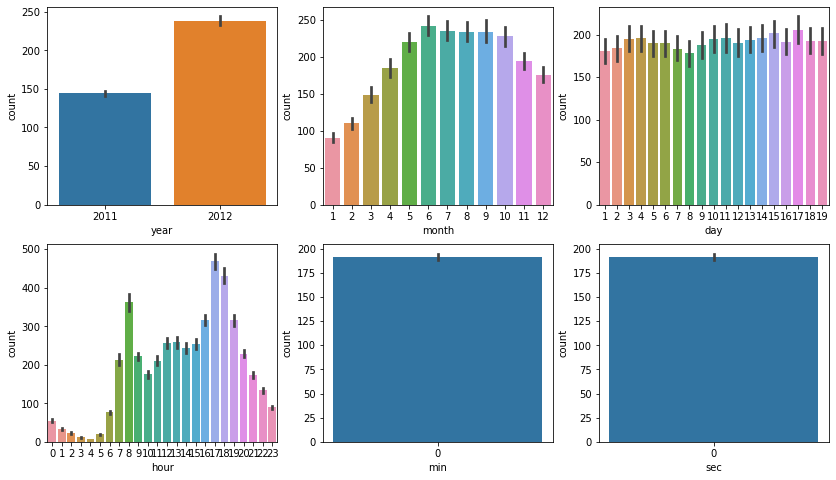

In [9]:
#시간별 바이크 대여 수 시각화
figure, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(14,8)
sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)
sns.barplot(data=train, x='day', y='count', ax=ax3)
sns.barplot(data=train, x='hour', y='count', ax=ax4)
sns.barplot(data=train, x='min', y='count', ax=ax5)
sns.barplot(data=train, x='sec', y='count', ax=ax6)

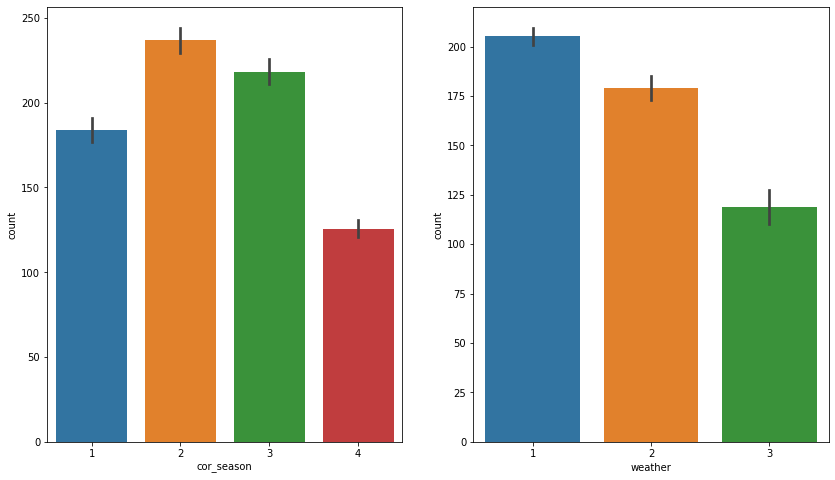

In [10]:
#시간별 바이크 대여 수 시각화2
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,8)
sns.barplot(data=train, x='cor_season', y='count', ax=ax1)
sns.barplot(data=train, x='weather', y='count', ax=ax2)

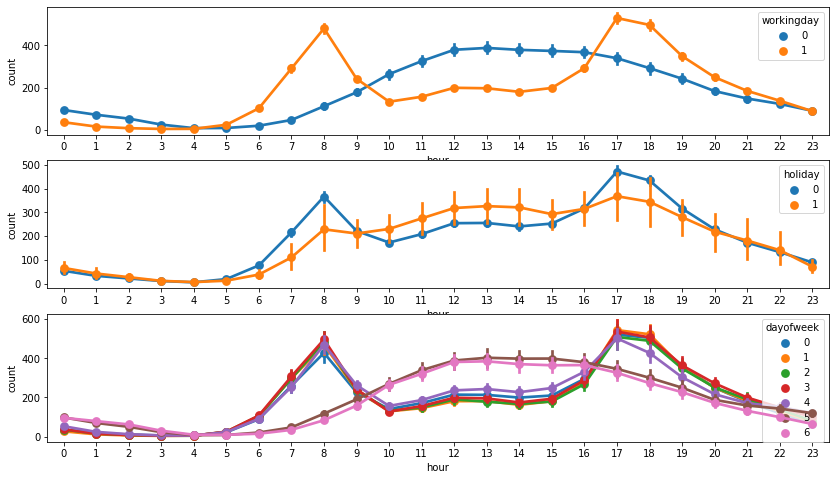

In [11]:
#근무일, 휴일, 요일을 시간단위 별로 시각화
figure, ((ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(14,8)
sns.pointplot(data = train, x='hour', y='count', hue = 'workingday', ax=ax1)
sns.pointplot(data = train, x='hour', y='count', hue = 'holiday', ax=ax2)
sns.pointplot(data = train, x='hour', y='count', hue = 'dayofweek', ax=ax3)

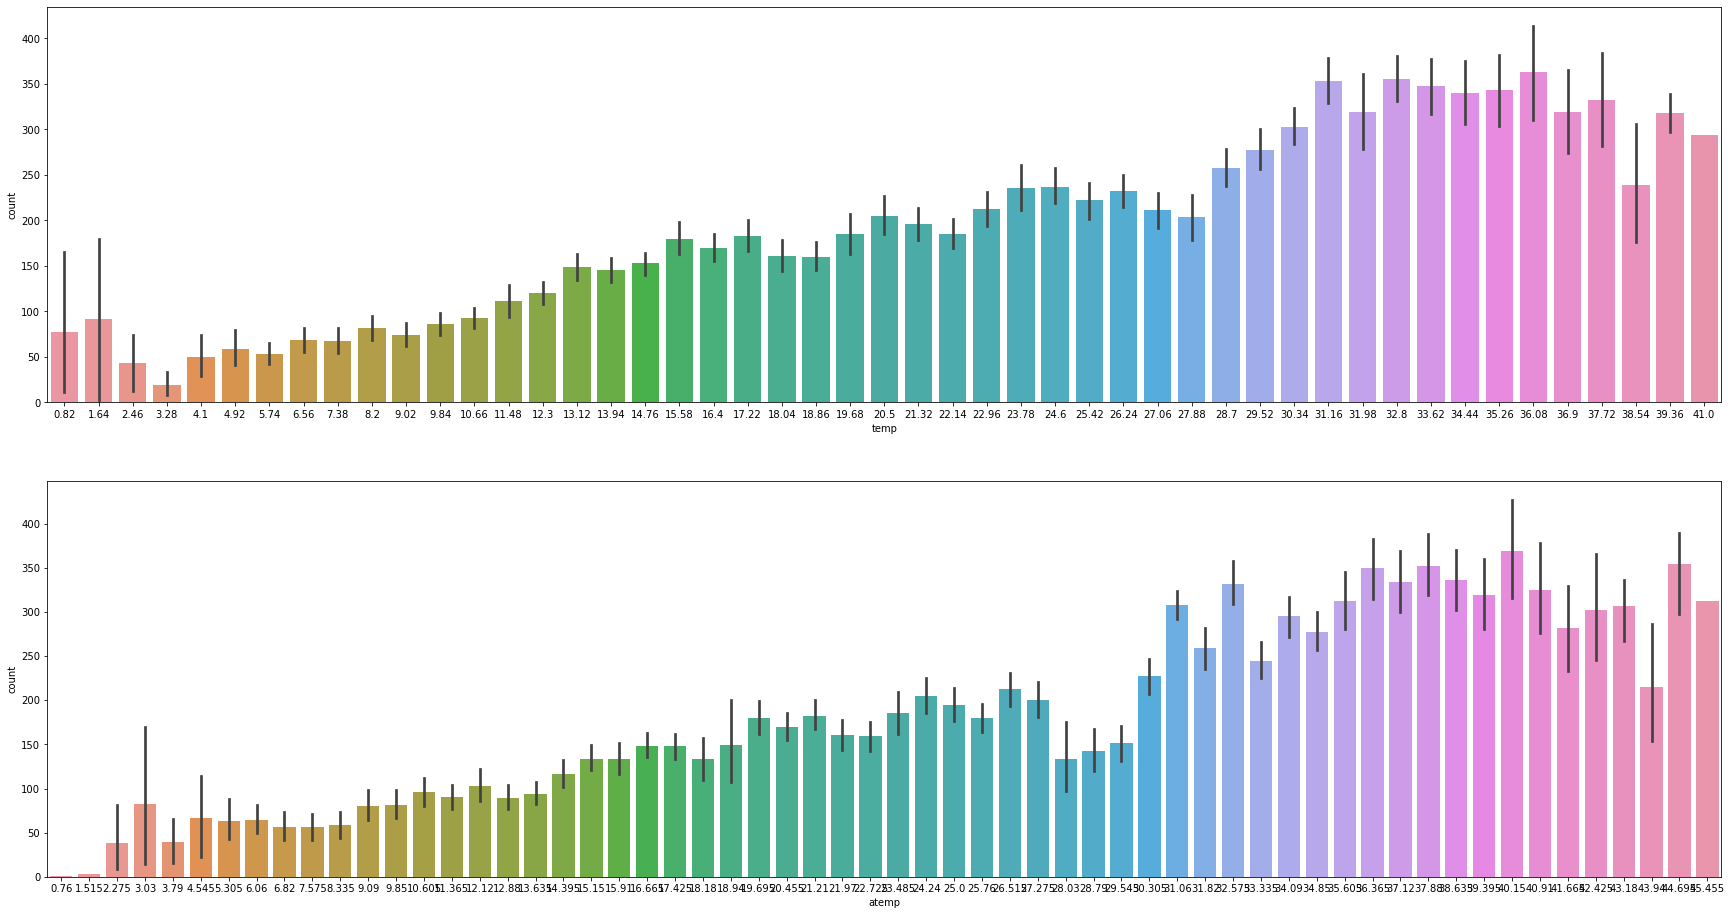

In [12]:
#온도, 체감온도 시각화
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(30,16)
sns.barplot(data=train, x='temp', y='count', ax=ax1)
sns.barplot(data=train, x='atemp', y='count', ax=ax2)

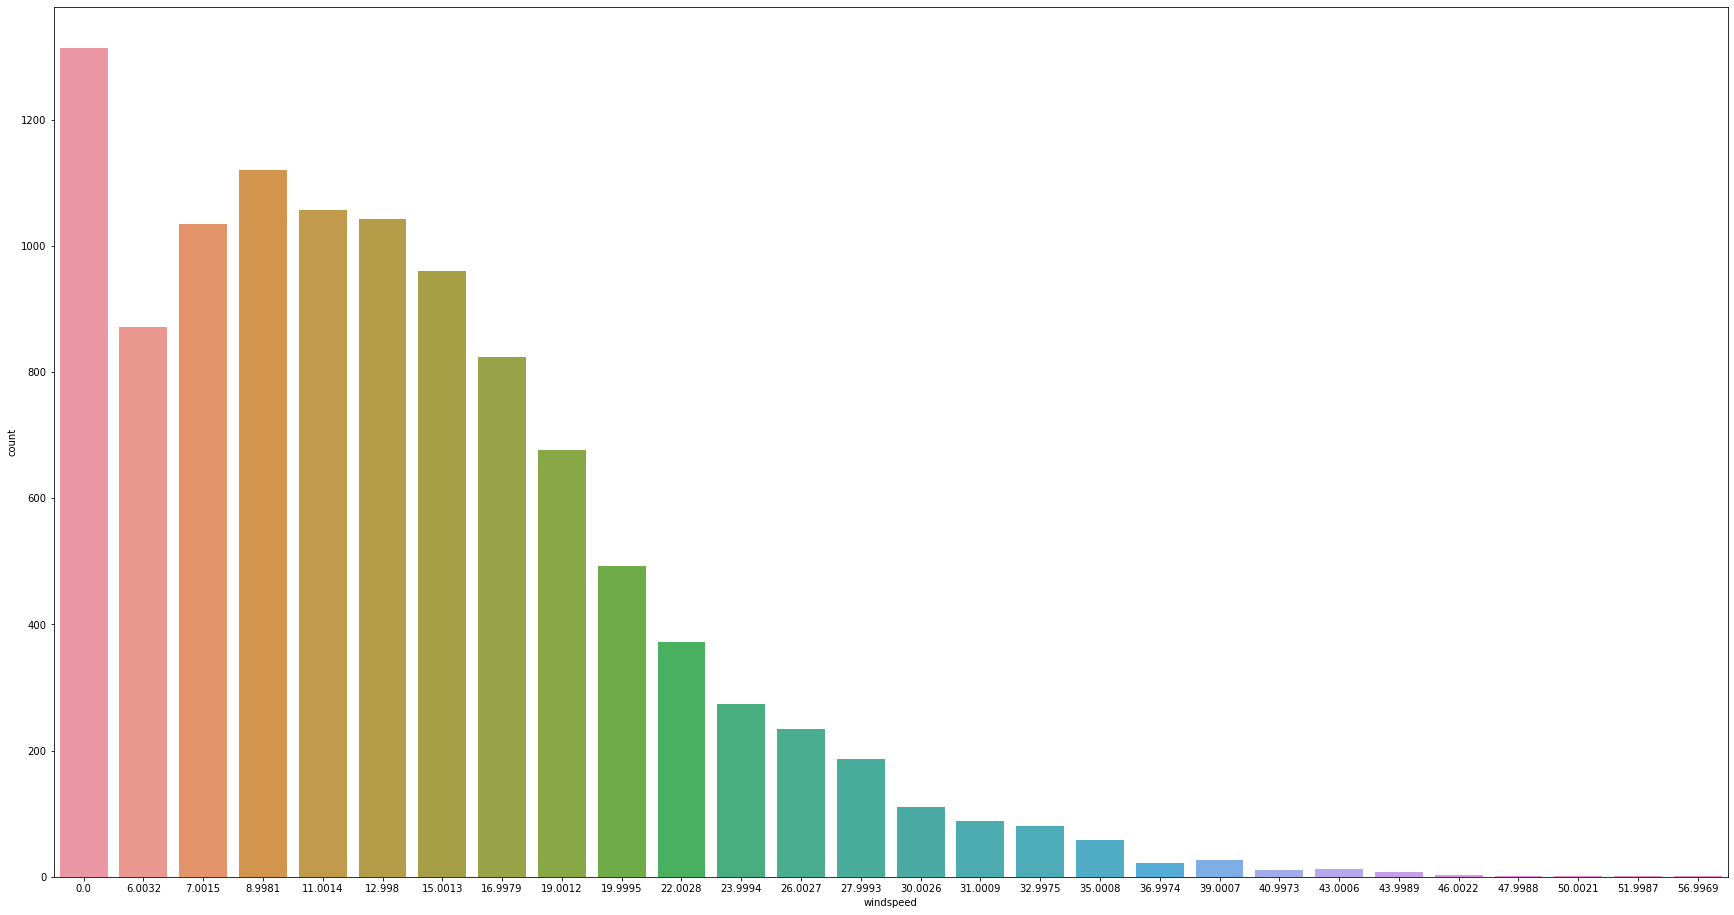

In [13]:
figure, (ax1) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(30,16)
sns.countplot(x='windspeed',data=train, ax=ax1)

# windspeed 모델링

In [14]:
windspeed_zero = train[train['windspeed'] == 0]
windspeed_notzero = train[train['windspeed'] != 0]

In [15]:
windspeed_x_train = windspeed_notzero[['temp','atemp','weather','humidity','month','hour','year','day','cor_season']]
windspeed_y_train = windspeed_notzero['windspeed']
windspeed_x_test = windspeed_zero[['temp','atemp','weather','humidity','month','hour','year','day','cor_season']]
windspeed_x_train.head()

,temp,atemp,weather,humidity,month,hour,year,day,cor_season
5,9.84,12.880,2,75,1,5,2011,1,4
10,15.58,19.695,1,76,1,10,2011,1,4
11,14.76,16.665,1,81,1,11,2011,1,4
12,17.22,21.210,1,77,1,12,2011,1,4
13,18.86,22.725,2,72,1,13,2011,1,4


In [16]:
#랜덤 포레스트를 이용한 회귀 분석
windspeed_model= RandomForestRegressor()
windspeed_model.fit(windspeed_x_train, windspeed_y_train)

c:\users\user\pycharmprojects\githubassign\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [17]:
windspeed_zero['windspeed']=windspeed_model.predict(windspeed_x_test)

c:\users\user\pycharmprojects\githubassign\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
windspeed=pd.concat([windspeed_zero, windspeed_notzero], axis=0)['windspeed']
train['windspeed']=windspeed
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,min,sec,dayofweek,cor_season
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,12.10221,3,13,16,2011,1,1,0,0,0,5,4
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,10.50225,8,32,40,2011,1,1,1,0,0,5,4
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,10.50225,5,27,32,2011,1,1,2,0,0,5,4
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,9.60177,3,10,13,2011,1,1,3,0,0,5,4
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,9.60177,0,1,1,2011,1,1,4,0,0,5,4


In [19]:
train['windspeed'].value_counts().head()

8.9981     1120
11.0014    1060
12.9980    1042
7.0015     1041
15.0013     961
Name: windspeed, dtype: int64

# 속성 선택

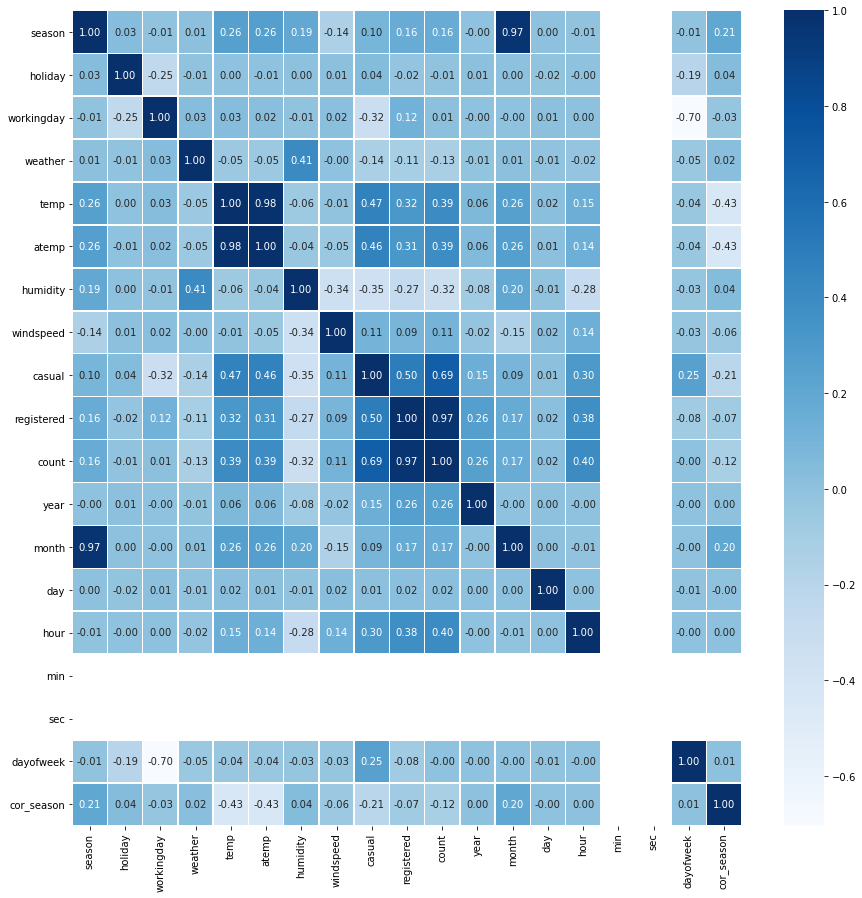

In [20]:
#각 속성 상관관계 히트맵으로 시각화
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [21]:
#상관관계 분석결과 불필요한 속성 삭제
train.drop(['datetime','season','min','sec','casual','registered','dayofweek'], axis=1, inplace=True)

In [22]:
train.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,cor_season
0,0,0,1,9.84,14.395,81,12.10221,16,2011,1,1,0,4
1,0,0,1,9.02,13.635,80,10.50225,40,2011,1,1,1,4
2,0,0,1,9.02,13.635,80,10.50225,32,2011,1,1,2,4
3,0,0,1,9.84,14.395,75,9.60177,13,2011,1,1,3,4
4,0,0,1,9.84,14.395,75,9.60177,1,2011,1,1,4,4


# 테스트 데이터 전처리

In [23]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [24]:
#datetime을 시간 단위 별로 구분
test['datetime']=pd.to_datetime(test['datetime'])
test['year']=test['datetime'].dt.year
test['month']=test['datetime'].dt.month
test['day']=test['datetime'].dt.day
test['hour']=test['datetime'].dt.hour
test['min']=test['datetime'].dt.minute
test['sec']=test['datetime'].dt.second
test['dayofweek']=test['datetime'].dt.dayofweek
test[['datetime','year','month','day','hour','min','sec','dayofweek']].head()

,datetime,year,month,day,hour,min,sec,dayofweek
0,2011-01-20 00:00:00,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,2011,1,20,4,0,0,3


In [25]:
#season 오류 수정
test['cor_season']=test['season']
for i in range(test.shape[0]):
    if test.loc[i, 'month'] in [3, 4, 5]:
        test.loc[i, 'cor_season']=1
    elif test.loc[i, 'month'] in [6,7,8]:
        test.loc[i, 'cor_season']=2
    elif test.loc[i, 'month'] in [9,10,11]:
        test.loc[i, 'cor_season']=3
    elif test.loc[i, 'month'] in [12,1,2]:
        test.loc[i, 'cor_season']=4

In [26]:
#테스트 데이터도 동일한 방법으로 모델링을 windspeed 재정의
windspeed_zero_test = test[test['windspeed'] == 0]
windspeed_notzero_test = test[test['windspeed'] != 0]
windspeed_x_test = windspeed_notzero_test[['temp','atemp','weather','humidity','month','hour','year','day','cor_season']]
windspeed_y_test = windspeed_notzero_test['windspeed']
windspeed_x_test_test = windspeed_zero_test[['temp','atemp','weather','humidity','month','hour','year','day','cor_season']]
windspeed_model_test= RandomForestRegressor()
windspeed_model_test.fit(windspeed_x_test, windspeed_y_test)
windspeed_zero_test['windspeed']=windspeed_model.predict(windspeed_x_test_test)
windspeed_test=pd.concat([windspeed_zero_test, windspeed_notzero_test], axis=0)['windspeed']
test['windspeed']=windspeed_test
test.head()

c:\users\user\pycharmprojects\githubassign\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\pycharmprojects\githubassign\venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,min,sec,dayofweek,cor_season
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.00270,2011,1,20,0,0,0,3,4
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,12.09886,2011,1,20,1,0,0,3,4
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,11.89853,2011,1,20,2,0,0,3,4
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.00140,2011,1,20,3,0,0,3,4
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.00140,2011,1,20,4,0,0,3,4


In [27]:
test['windspeed'].value_counts()

11.00140    642
8.99810     618
12.99800    615
7.00150     584
6.00320     554
           ... 
11.89987      1
9.49993       1
12.30053      1
11.10056      1
16.19926      1
Name: windspeed, Length: 613, dtype: int64

In [28]:
#불필요 속성 삭제
test.drop(['datetime','season','min','sec','dayofweek'], axis=1, inplace=True)

In [29]:
test.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,cor_season
0,0,1,1,10.66,11.365,56,26.00270,2011,1,20,0,4
1,0,1,1,10.66,13.635,56,12.09886,2011,1,20,1,4
2,0,1,1,10.66,13.635,56,11.89853,2011,1,20,2,4
3,0,1,1,10.66,12.880,56,11.00140,2011,1,20,3,4
4,0,1,1,10.66,12.880,56,11.00140,2011,1,20,4,4


# 모델링

(array([4284., 2336., 1686., 1067.,  633.,  426.,  233.,  116.,   85.,
          19.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

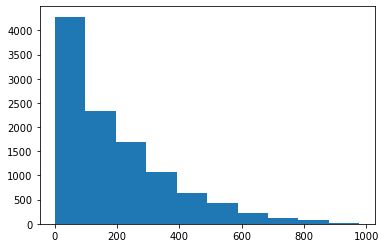

In [30]:
plt.hist(train['count'])

###### count의 수치가 편중되어 있으므로 모델링 전 로그화 필요

(array([ 237.,  462.,  625.,  626.,  805., 1076., 1768., 2543., 2058.,
         685.]),
 array([0.69314718, 1.31238343, 1.93161968, 2.55085593, 3.17009218,
        3.78932843, 4.40856467, 5.02780092, 5.64703717, 6.26627342,
        6.88550967]),
 <a list of 10 Patch objects>)

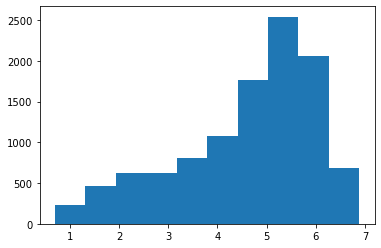

In [31]:
train['count_log']=np.log(train['count']+1)
plt.hist(train['count_log'])

In [32]:
#모델링을 위해 독립변수, 종속변수 분리
y_train=train['count_log']
train.drop(['count','count_log'], axis=1, inplace=True)

###### 그리드서치를 통해 유효한 모델 및 파라미터 선택

In [33]:
#본 competition은 RMSLE 방식을 이용하여 평가하므로 스코어링 방식을 정의
def rmsle(y, yhat):
    sub=y-yhat
    square=np.square(sub)
    mean=np.mean(square)
    score=np.sqrt(mean)
    return score
rmsle_scorer=make_scorer(rmsle, greater_is_better=False)

In [34]:
#선형 회귀 모델
#찾을 파라미터가 별도로 없으므로 그리드서치 미사용
model_lr= LinearRegression()
model_lr.fit(train, y_train)
preds_lr = model_lr.predict(train)
print('선형 회귀 모델 RMSLE 점수 : ' + rmsle(y_train, preds_lr).astype('str'))

선형 회귀 모델 RMSLE 점수 : 1.0162194394432178


In [35]:
#랜덤 포레스트 모델
model_rf=RandomForestRegressor()
rf_params= {'n_estimators' : [70, 80],
            'max_depth' : [60, 90],
           'max_features' : [0.7, 0.9],
           'n_jobs' : [3],
            'random_state' : [7]
           }
rf_grid=GridSearchCV(model_rf, rf_params, scoring=rmsle_scorer, cv=3)
rf_grid.fit(train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [60, 90], 'max_fea

In [36]:
preds_rf = rf_grid.predict(train)
print('랜덤 포레스트 모델 RMSLE 점수 : ' + rmsle(y_train, preds_rf).astype('str'))

랜덤 포레스트 모델 RMSLE 점수 : 0.11977811211635667


In [38]:
#xgboost 모델
model_xgb=XGBRegressor()
xgb_params= {'n_estimators' : [200, 300],
           'max_depth' : [3, 4]}
xgb_grid=GridSearchCV(model_xgb, xgb_params, scoring=rmsle_scorer, cv=3)
xgb_grid.fit(train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constrain...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_p

In [39]:
preds_xgb = xgb_grid.predict(train)
print('xgboost 모델 RMSLE 점수 : ' + rmsle(y_train, preds_xgb).astype('str'))

xgboost 모델 RMSLE 점수 : 0.27998800190994877


In [40]:
#그레디언트 부스팅 모델
model_gb=GradientBoostingRegressor()
gb_params= {'max_depth' : [3, 5],
           'n_estimators' : [50, 100]}
gb_grid=GridSearchCV(model_gb, gb_params, scoring=rmsle_scorer, cv=3)
gb_grid.fit(train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                

In [41]:
preds_gb = gb_grid.predict(train)
print('그레디언트 부스팅 모델 RMSLE 점수 : ' + rmsle(y_train, preds_gb).astype('str'))

그레디언트 부스팅 모델 RMSLE 점수 : 0.276837395322301


In [42]:
#RMSLE 점수가 가장 작은 랜덤 포레스트 모델 사용하여 결과 CSV 저장
y_preds = rf_grid.predict(test)
test['count']=np.exp(y_preds)-1
sample = pd.read_csv('./data_bike/sampleSubmission.csv')
sample['count']=test['count']
sample.to_csv('./data_bike/result.csv', index=False)
test.drop(['count'], axis=1, inplace=True)

In [43]:
sample

,datetime,count
0,2011-01-20 00:00:00,10.956924
1,2011-01-20 01:00:00,4.667201
2,2011-01-20 02:00:00,3.900966
3,2011-01-20 03:00:00,3.312136
4,2011-01-20 04:00:00,2.483347
...,...,...
6488,2012-12-31 19:00:00,315.209346
6489,2012-12-31 20:00:00,229.444838
6490,2012-12-31 21:00:00,156.714651
6491,2012-12-31 22:00:00,119.548113
